## EDA
#### References:
https://www.kaggle.com/angqx95/feature-extractor-fine-tuning-with-keras

In [49]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

image_size = 224
input_shape = (image_size, image_size, 3)
batch_size = 16

## Load data

In [24]:
data_dir = 'input/cats-and-dogs'
print(len(os.listdir(data_dir+'/train')), "training data")
print(len(os.listdir(data_dir+'/test')), "test data")
os.listdir(data_dir)

1000 training data
100 test data


['train', 'valid', 'test']

In [43]:
def gen_label(directory):
    label = []
    for file in os.listdir(data_dir+directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label
    #print(len(label),"files in", directory)
    
def get_path(directory):
    path = []
    for files in os.listdir(data_dir+ directory):
        path.append(files)
    return path

train_y = gen_label('/train')
train_x = get_path('/train')
test_x = get_path('/test')
test_y = gen_label('/test')

### Class distribution

        filename category
0   dog.5225.jpg        1
1  dog.10616.jpg        1
2   dog.4496.jpg        1
3  cat.10364.jpg        0
4    cat.233.jpg        0


Text(0.5, 1.0, 'Train Data Distribution')

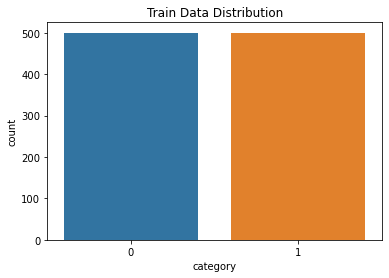

In [42]:
df = pd.DataFrame({'filename': train_x,
                  'category': train_y})
print(df.head())

sns.countplot(x='category',data=df).set_title("Train Data Distribution")

### Samples

In [33]:
IMAGE_FOLDER_PATH=data_dir+"/train"
FILE_NAMES=os.listdir(IMAGE_FOLDER_PATH)
WIDTH=150
HEIGHT=150

targets=list()
full_paths=list()
for file_name in FILE_NAMES:
    target=file_name.split(".")[0]
    full_path=os.path.join(IMAGE_FOLDER_PATH, file_name)
    full_paths.append(full_path)
    targets.append(target)

dataset=pd.DataFrame()
dataset['image_path']=full_paths
dataset['target']=targets

def get_side(img, side_type, side_size=5):
    height, width, channel=img.shape
    if side_type=="horizontal":
        return np.ones((height,side_size,  channel), dtype=np.float32)*255
        
    return np.ones((side_size, width,  channel), dtype=np.float32)*255

def show_gallery(show="both"):
    n=100
    counter=0
    images=list()
    vertical_images=[]
    rng_state = np.random.get_state()
    np.random.shuffle(full_paths)
    np.random.set_state(rng_state)
    np.random.shuffle(targets)
    for path, target in zip(full_paths, targets):
        if target!=show and show!="both":
            continue
        counter=counter+1
        if counter%100==0:
            break
        #Image loading from disk as JpegImageFile file format
        img=load_img(path, target_size=(WIDTH,HEIGHT))
        #Converting JpegImageFile to numpy array
        img=img_to_array(img)
        
        hside=get_side(img, side_type="horizontal")
        images.append(img)
        images.append(hside)

        if counter%10==0:
            himage=np.hstack((images))
            vside=get_side(himage, side_type="vertical")
            vertical_images.append(himage)
            vertical_images.append(vside)
            
            images=list()

    gallery=np.vstack((vertical_images)) 
    plt.figure(figsize=(12,12))
    plt.xticks([])
    plt.yticks([])
    title={"both":"Dogs and Cats",
          "cat": "Cats",
          "dog": "Dogs"}
    plt.title("100 samples of {} of the dataset".format(title[show]))
    plt.imshow(gallery.astype(np.uint8))

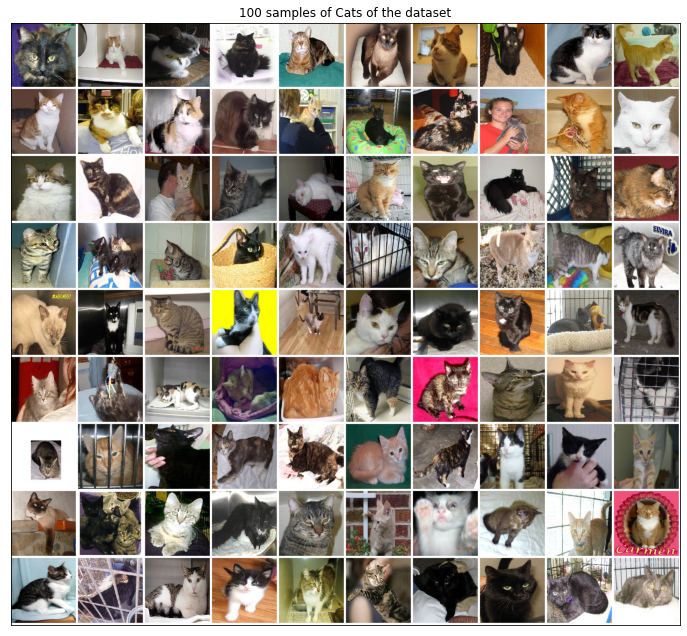

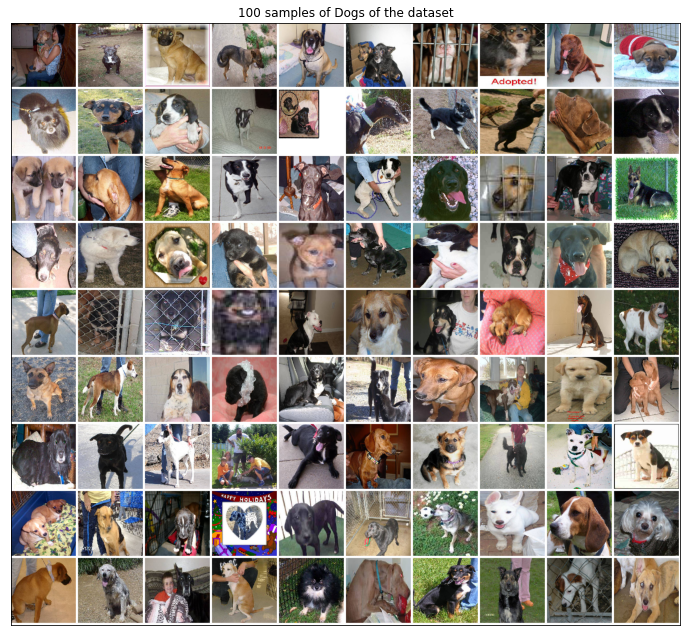

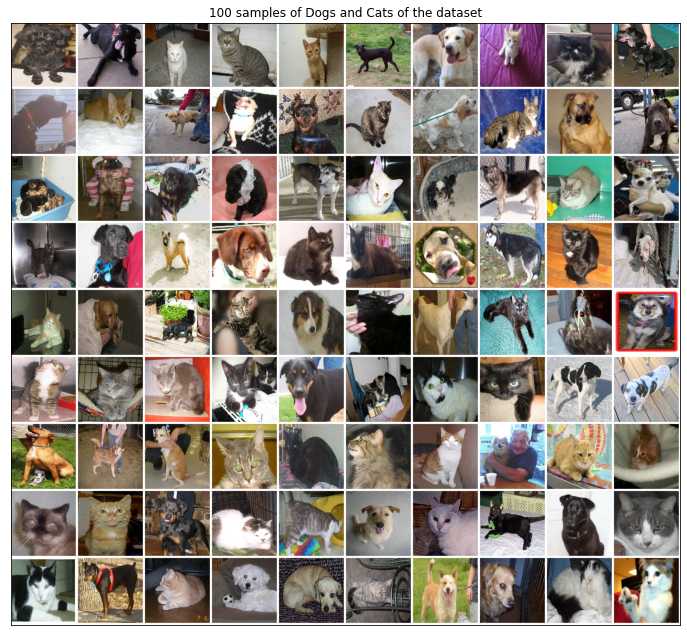

In [36]:
show_gallery(show="cat")
show_gallery(show="dog")
show_gallery(show="both")

* There are many different types of cats
* There are many different types of dogs
* Some cat (dog) breeds are very similar to some dog (cat) breeds.
* The backgrounds in the images are very different and noisy.
* The difference in exposure of cats and dogs in the images is quite high.

### Traning Generator - Augmentation 

In [44]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [54]:
train_generator = train_datagen.flow_from_dataframe(
    df, 
    data_dir+"/train/", 
    x_col='filename',
    y_col='category',
    class_mode='binary',
    target_size=(image_size, image_size),
    batch_size=batch_size
)

Found 1000 validated image filenames belonging to 2 classes.


### See sample generated images

Found 1 validated image filenames belonging to 1 classes.


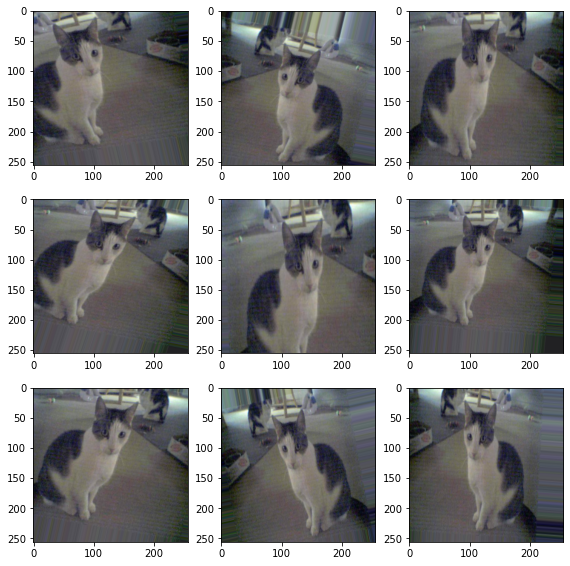

In [58]:
example_df = df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    data_dir+"/train/", 
    x_col='filename',
    y_col='category'
)
plt.figure(figsize=(8, 8))
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()